# 06: Creating multiple CF-NetCDF files in one go

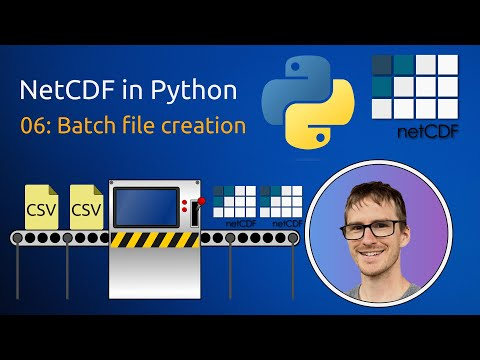

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('TjL23unMMWI')

In some cases, people will choose to break down their data into multiple smaller netcdf files that they will publish in a single data collection. There are a number of good reasons to do this.
* The data user can access only the data they are interested in.
* Each file can be simpler with potentially less dimensions and less missing values. Imagine you have 10 depth profiles that all sample a different set of depths. If these profiles were included in a single netcdf file, the file would most likely a single depth dimension and coordinate variable which would need to account for all 10 depth profiles. Alternatively, 10 depth dimensions and coordinate variables could be included, but this is considered bad practice.
* Each individual file can be assigned a separate set of global attributes which describe the data more accurately. For example each file could have global attributes for the coordinates and timestamp. If multiple depth profiles are stored in a single file, only the minimum and maximum coordinates and timestamp can be encoded into the global attributes.
* Imagine you are looking for data in a data centre. You want to find depth profiles in a certain area of interest on a map. Files that include a single depth profile will be presented as points on the map. Files that include multiple depth profiles will be presented as a bounding box on a map, and without opening up the file it could be unclear whether the file includes data for your area of interest.

One might think that this would involve more work for the data creator and user. However, if the files are similar (and they should be if they follow the CF and ACDD conventions) this is not neccessarily the case.

In this notebook we will look at we can easily create multiple NetCDF files in one go using Python. 

Imagine you have multiple depth profiles. The two most likely ways your data are structured are:
* 1 tabular file per depth profile
* All profiles in 1 tabular file

In this tutorial we present an example with a 1 tabular file per depth profile. If your data are stored altogether in one file, the first thing you will need to do is separate them. You can do this manually before you start or in your code.

## A refresh of how to create a single NetCDF file

Let's start with some code to create one basic CF-NetCDF file.

In [2]:
import pandas as pd
import xarray as xr
from datetime import datetime
import glob
import numpy as np
import json
import yaml

# Get the current timestamp in UTC and format it in ISO8601
time_now = datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%SZ')

df = pd.read_csv('../data/csv_files/depth_profile_S1.csv')

# Create an xarray dataset from the dataframe
xrds = xr.Dataset(
    coords={
        'pressure': df['Pressure']
    },
    data_vars={
        'Temperature': ('pressure', df['Temperature']),
        'Salinity': ('pressure', df['Salinity']),
    } 
)

# Add attributes to make it CF-compliant
xrds['Temperature'].attrs = {
    'standard_name': 'sea_water_temperature',
    'long_name': 'Temperature of sea water',
    'units': 'degrees_Celsius',
    'coverage_content_type': 'physicalMeasurement'
}
xrds['Salinity'].attrs = {
    'standard_name': 'sea_water_salinity',
    'long_name': 'Salinity of sea water',
    'units': 'PSU',
    'coverage_content_type': 'physicalMeasurement'
}
xrds['pressure'].attrs = {
    'standard_name': 'sea_water_pressure',
    'long_name': 'Sea water pressure',
    'units': 'dbar',
    'coverage_content_type': 'coordinate'
}

# Global attributes based on these requirements
# https://adc.met.no/node/4
# Based on the Attribute Convention for Data Discovery (ACDD) and Climate & Forecast (CF) conventions
xrds.attrs = {
    'id': 'your_unique_id_here',
    'naming_authority': 'institution that provides the id',
    'title': 'Depth Profile Data',
    'summary': 'This dataset contains depth profiles of temperature and salinity measurements.',
    'keywords': 'sea_water_temperature, sea_water_salinity',
    'keywords_vocabulary': 'CF:NetCDF COARDS Climate and Forecast Standard Names',
    'geospatial_lat_min': 80.6713,
    'geospatial_lat_max': 80.6713,
    'geospatial_lon_min': 31.2093,
    'geospatial_lon_max': 31.2093,
    'time_coverage_start': '2020-04-26T09:56:00Z',
    'time_coverage_end': '2020-04-26T09:56:00Z',
    'Conventions': 'ACDD-1.3, CF-1.11',
    'history': f'{time_now}: Modified by YourName using Python',
    'source': 'Measurement',
    'processing_level': 'Level of processing/quality control',
    'date_created': time_now,
    'creator_type': 'person',
    'creator_institution': 'Your Institution',
    'creator_name': 'Your Name',
    'creator_email': 'your@email.com',
    'creator_url': 'your_url_here', # OrcID is best practice, e.g. https://orcid.org/0000-0002-9746-544X
    'institution': 'Your Institution',
    'publisher_name': 'Publisher Name', # Data centre where your data will be published
    'publisher_email': 'publisher@email.com',
    'publisher_url': 'publisher_url_here',
    'project': 'Your Project Name',
    'instrument': 'CTD',
    'instrument_vocabulary': 'http://vocab.nerc.ac.uk/collection/L22/current/TOOL0001/',
    'license': 'https://creativecommons.org/licenses/by/4.0/',
    'featureType': 'profile',
    'station_name': 'S1' # Custom attribute, but you can add any attribute you like alongside the minimum requirements.
}

# Save the dataset to a NetCDF file
xrds.to_netcdf('../data/netcdf_files/06_depth_profile_one_file.nc')
xrds

<xarray.Dataset>
Dimensions:      (pressure: 10)
Coordinates:
  * pressure     (pressure) float64 39.46 58.12 57.36 3.418 ... 2.231 67.68 83.0
Data variables:
    Temperature  (pressure) float64 1.955 1.42 1.715 2.844 ... 1.394 2.004 1.583
    Salinity     (pressure) float64 34.7 34.84 34.73 35.35 ... 35.15 35.48 34.66
Attributes: (12/32)
    id:                     your_unique_id_here
    naming_authority:       institution that provides the id
    title:                  Depth Profile Data
    summary:                This dataset contains depth profiles of temperatu...
    keywords:               sea_water_temperature, sea_water_salinity
    keywords_vocabulary:    CF:NetCDF COARDS Climate and Forecast Standard Names
    ...                     ...
    project:                Your Project Name
    instrument:             CTD
    instrument_vocabulary:  http://vocab.nerc.ac.uk/collection/L22/current/TO...
    license:                https://creativecommons.org/licenses/by/4.0/
    featureType:            profile
    station_name:           S1

## A quick introduction to for loops

A for loop is a way to do the same thing multiple times for different items in a list or collection. Let's firstly demonstrate how a for loop works for those who are unfamiliar. 

In [3]:
numbers = [1, 2, 3, 4, 5]

# Use a for loop to iterate through the list
for number in numbers:
    print('Printing number',number)

Printing number 1
Printing number 2
Printing number 3
Printing number 4
Printing number 5


## Looping through CSV files that contain your data

Hopefully all your tabular files are structured in the same way with the same column headers. If not, fix this first! 

Imagine you have a directory that has multiple CSV files in it, each one containing a depth profile. Let's loop through each file and load it.

In [4]:
folder_path = '../data/csv_files/' # Path to the folder containing CSV files
files = glob.glob(folder_path + '*.csv') # Get a list of file paths for all CSV files in the folder

for file in files:
    df = pd.read_csv(file)
    print(f'Opened {file}')    

Opened ../data/csv_files/depth_profile_S4.csv
Opened ../data/csv_files/depth_profile_S5.csv
Opened ../data/csv_files/depth_profile_S2.csv
Opened ../data/csv_files/depth_profile_S1.csv
Opened ../data/csv_files/depth_profile_S3.csv
Opened ../data/csv_files/depth_profile_S7.csv
Opened ../data/csv_files/depth_profile_S8.csv
Opened ../data/csv_files/depth_profile_S6.csv


To assign a different file name for each NetCDF file, we need to include a variable in the filename that is different for each loop iteration - perhaps some function of the input filename.

In [5]:
folder_path = '../data/csv_files/' # Path to the folder containing CSV files
files = glob.glob(folder_path + '*.csv') # Get a list of file paths for all CSV files in the folder

for file in files:    
    station = file.split('_')[-1].split('.')[0]
    print(station)

S4
S5
S2
S1
S3
S7
S8
S6


## Different global attributes for each NetCDF file

What about the global attributes? Some attributes might be the same for every file, like the creator and publisher details. However, other attributes will be different for each file.

We are going to store the metadata in a separate file and load it in. Here are 3 examples - go and look at the files themselves if you want to create your own.

### JSON:

In [6]:
# Read the JSON file
with open('../data/metadata_files/depth_profiles_metadata.json', 'r') as json_file:
    metadata = json.load(json_file)
    
# The data are loaded into a Python dictionary that you can easily access.
for station, info in metadata.items():
    print(f"Station: {station}")
    print(f"Latitude: {info['latitude']}")

Station: S1
Latitude: 27.125
Station: S2
Latitude: 27.128
Station: S3
Latitude: 27.123
Station: S4
Latitude: 27.126
Station: S5
Latitude: 27.122
Station: S6
Latitude: 27.124
Station: S7
Latitude: 27.127
Station: S8
Latitude: 27.125


### YAML

In [7]:
# Read the YAML file
with open('../data/metadata_files/depth_profiles_metadata.json', 'r') as yaml_file:
    metadata = yaml.safe_load(yaml_file)

# The data are loaded into a Python dictionary that you can easily access.
for station, info in metadata.items():
    print(f"Station: {station}")
    print(f"Latitude: {info['latitude']}")

Station: S1
Latitude: 27.125
Station: S2
Latitude: 27.128
Station: S3
Latitude: 27.123
Station: S4
Latitude: 27.126
Station: S5
Latitude: 27.122
Station: S6
Latitude: 27.124
Station: S7
Latitude: 27.127
Station: S8
Latitude: 27.125


### CSV

In [8]:
# Read the CSV file into a pandas DataFrame
metadata_df = pd.read_csv('../data/metadata_files/depth_profiles_metadata.csv')

# Loop through each row in the DataFrame
for index, row in metadata_df.iterrows():
    print(f"Station: {row['Station']}")
    print(f"Latitude: {row['latitude']}")

Station: S1
Latitude: 27.125
Station: S2
Latitude: 27.128
Station: S3
Latitude: 27.123
Station: S4
Latitude: 27.126
Station: S5
Latitude: 27.122
Station: S6
Latitude: 27.124
Station: S7
Latitude: 27.127
Station: S8
Latitude: 27.125


## Looping through the data and global attributes at the same time

We need to loop through both the data files and the files containing the global attributes at the same time. The key here is to have something that links the two. In this case, we have the station name in the data file name and in the global attributes metadata files.

In this case we will proceed with the YAML file, but hopefully you can incorporate the code below yourself if you would rather work with JSON or CSV files.

In [9]:
# Read the YAML file
with open('../data/metadata_files/depth_profiles_metadata.json', 'r') as yaml_file:
    metadata = yaml.safe_load(yaml_file)
    
data_files = glob.glob(folder_path + '*.csv') # Get a list of file paths for all the data files in the folder

for data_file in data_files: # Looping through each data file
    data_df = pd.read_csv(data_file)
    station = data_file.split('_')[-1].split('.')[0] # Extracting the station name from the file path
    
    metadata_station = metadata[station]
    print(metadata_station)    

{'latitude': 27.126, 'longitude': 29.993, 'timestamp': '2023-06-15T10:45:00Z', 'id': 'f7a6c89d-4c3e-4a94-8e9a-04a7f8f43d6c'}
{'latitude': 27.122, 'longitude': 29.996, 'timestamp': '2023-06-15T10:50:00Z', 'id': 'd8eb21f2-43a6-4b18-9c6c-8f8b30051718'}
{'latitude': 27.128, 'longitude': 29.998, 'timestamp': '2023-06-15T10:35:00Z', 'id': 'cc29745a-925b-45d0-8b88-ce967322b6c4'}
{'latitude': 27.125, 'longitude': 29.995, 'timestamp': '2023-06-15T10:30:00Z', 'id': '3b89f178-8c48-4fc4-ae7d-27e2f4c6d9e1'}
{'latitude': 27.123, 'longitude': 29.997, 'timestamp': '2023-06-15T10:40:00Z', 'id': 'a43de701-3bfe-4c7e-a78b-1d87a9af1122'}
{'latitude': 27.127, 'longitude': 29.995, 'timestamp': '2023-06-15T11:00:00Z', 'id': '5f2c68c1-68d7-4d3b-aa2b-254c73e4b59e'}
{'latitude': 27.125, 'longitude': 29.999, 'timestamp': '2023-06-15T11:05:00Z', 'id': 'e4c040e2-1506-4099-85f1-99e0e47244f7'}
{'latitude': 27.124, 'longitude': 29.994, 'timestamp': '2023-06-15T10:55:00Z', 'id': '9b4e0d0a-51d9-4d5b-a144-0a8c97cc1181'}


## Creating multiple CF-NetCDF files

Now let's put all of this together to create our NetCDF files.

In [10]:
# Read the YAML file
with open('../data/metadata_files/depth_profiles_metadata.json', 'r') as yaml_file:
    metadata = yaml.safe_load(yaml_file)
    
data_files = glob.glob(folder_path + '*.csv') # Get a list of file paths for all the data files in the folder

for data_file in data_files: # Looping through each data file
    data_df = pd.read_csv(data_file)
    station = data_file.split('_')[-1].split('.')[0] # Extracting the station name from the file path
    
    metadata_station = metadata[station]
    
    # Create an xarray dataset from the dataframe
    xrds = xr.Dataset(
        coords={
            'pressure': data_df['Pressure']
        },
        data_vars={
            'Temperature': ('pressure', data_df['Temperature']),
            'Salinity': ('pressure', data_df['Salinity']),
        } 
    )

    # Add variable attributes
    xrds['Temperature'].attrs = {
        'standard_name': 'sea_water_temperature',
        'long_name': 'Temperature of sea water',
        'units': 'degrees_Celsius',
        'coverage_content_type': 'physicalMeasurement'
    }
    xrds['Salinity'].attrs = {
        'standard_name': 'sea_water_salinity',
        'long_name': 'Salinity of sea water',
        'units': 'PSU',
        'coverage_content_type': 'physicalMeasurement'
    }
    xrds['pressure'].attrs = {
        'standard_name': 'sea_water_pressure',
        'long_name': 'Sea water pressure',
        'units': 'dbar',
        'coverage_content_type': 'coordinate'
    }
    
    # Get the current timestamp in UTC and format it in ISO8601
    time_now = datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%SZ')
    
    xrds.attrs = {
        'id': metadata_station['id'],
        'naming_authority': 'institution that provides the id',
        'title': 'Depth Profile Data',
        'summary': 'This dataset contains depth profiles of temperature and salinity measurements.',
        'keywords': 'sea_water_temperature, sea_water_salinity',
        'keywords_vocabulary': 'CF:NetCDF COARDS Climate and Forecast Standard Names',
        'geospatial_lat_min': metadata_station['latitude'],
        'geospatial_lat_max': metadata_station['latitude'],
        'geospatial_lon_min': metadata_station['longitude'],
        'geospatial_lon_max': metadata_station['longitude'],
        'time_coverage_start': metadata_station['timestamp'],
        'time_coverage_end': metadata_station['timestamp'],
        'Conventions': 'ACDD-1.3, CF-1.11',
        'history': f'{time_now}: Modified by YourName using Python',
        'source': 'Measurement',
        'processing_level': 'Level of processing/quality control',
        'date_created': time_now,
        'creator_type': 'person',
        'creator_institution': 'Your Institution',
        'creator_name': 'Your Name',
        'creator_email': 'your@email.com',
        'creator_url': 'your_url_here', # OrcID is best practice, e.g. https://orcid.org/0000-0002-9746-544X
        'institution': 'Your Institution',
        'publisher_name': 'Publisher Name', # Data centre where your data will be published
        'publisher_email': 'publisher@email.com',
        'publisher_url': 'publisher_url_here',
        'project': 'Your Project Name',
        'instrument': 'CTD',
        'instrument_vocabulary': 'http://vocab.nerc.ac.uk/collection/L22/current/TOOL0001/',
        'license': 'https://creativecommons.org/licenses/by/4.0/',
        'featureType': 'profile',
        'station_name': station # Custom attribute, but you can add any attribute you like alongside the minimum requirements.
    }
    
    xrds.to_netcdf(f'../data/netcdf_files/06_depth_profile_{station}.nc')